# FORCAST Grism Spectra: Basic Inspection and Assessment


## Introduction

This recipe provides an overview and sample code (in Python) for plotting and assessing FORCAST grism data.  The FORCAST observing modes are described in the SOFIA Observer’s Handbooks, available from the [Proposing and Observing  page on the SOFIA website](https://www.sofia.usra.edu/researchers/proposing-and-observing); and the FORCAST data products are described in the [FORCAST GO Data Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_GO_HAndbook_RevC.pdf).  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the  FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-point-like) sources, a standard summation over a fixed aperture is used (see recipe on custom extractions for additional information).  See the FORCAST GO Data Handbook for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

Level 3 FORCAST grism data is written in FITS format as a 2-dimensional data array with a single header (for detailed description, see FORCAST GO Data Handbook).  The first line of the data array contains the wavelength ($\mu$m);
the second line contains the pipeline-reduced and flux calibrated spectrum (Jy); the third line contains the uncertainty (Jy); the fourth contains the estimated atmospheric transmission spectrum; and the fifth contains the instrumental response used in the flux calibration process (Me-/s/Jy, where "Me-" is 10^6 electrons).

Each FORCAST grism file contains the spectrum for a specific grism, which is indicated in the name of the file, e.g. "FORG111" would be a file containing data for the 11.1 $\mu$m grism.  The pipeline does *not* combine specta from different grisms,  this is left to the user.  

There are two data types for  LEVEL 3 FORCAST grism data:
1.  CAL files:  flux calibrated results from a single astronomical observation request (AOR); there can be multiple CAL files for a single AOR.
2.  CMB files:  combination of multiple CAL files into a single data file.  Usually there is only one CMB file for a single AOR.
Except for the provenance, the two datatypes are identical and hence the procedures below are equally valid for both.

The "error" spectrum is for the statistical uncertainty *only* and does not reflect systematic uncertainties in the absolute flux, for example losses due to slit misalignment or poor image quality (see below).   If absolute fluxes are required, it is highly recommended that additional imaging data are obtained at the same time in order to calibrate the grism spectra accurately.  

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the [SOFIA Science Archive](https://dcs.arc.nasa.gov/dataRetrieval/SearchScienceArchiveInfoBasic.jsp).
2. Sample Data (if desired):  For the examples in this recipe, we use the calibrated data for AB Aur from program 05_0138 (PI: Shuping), flight 434. The dataset consists of four LEVEL 3 CMB files, one file for each grism setting (G063, G111, G227, and G329), which can be downloaded from the DCS archive using the following search parameters (under Advanced Search):
        - Year = 2017
        - MissionID = 2017-09-27_FO_F434
        - PlanID = 05_0138
        - Instrument/Config = FORCAST / GRISM
        - Processing State = LEVEL_3
        - Product type = combspec
        - Target = "AB Aug"
The four files should be saved with their original names in a folder named "forcast-sample-data" in the same directory as this Python Notebook:
        - forcast-sample-data/F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits
        - forcast-sample-data/F0434_FO_GRI_0501382_FORG111_CMB_0234-0238.fits
        - forcast-sample-data/F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits
        - forcast-sample-data/F0434_FO_GRI_0501384_FORG329_CMB_0239-0246.fits

3. [FORCAST GO Handbook](https://www.sofia.usra.edu/sites/default/files/USpot_DCS_DPS/Documents/FORCAST_GO_HAndbook_RevC.pdf) for reference (latest version can be found on the [SOFIA Data Products](https://www.sofia.usra.edu/science/proposing-and-observing/data-products))

## Reading the File and Loading the Data into a Table Structure

First step is to read the FITS file for the grism of interest and load the data into a convenient set of table structures in Python.  We'll start with the G227 (22.7 $\mu$m) grism data.

In [1]:
from astropy.io import fits

#first open the file...
g227_fits = fits.open('forcast-sample-data/F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits')
#...and get info
g227_fits.info()

Filename: forcast-sample-data/F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     318   (236, 5)   float64   


The file contains a single HDU containing a 5 x 236 array.  Now place the data portion into a separate table structure for convenience:

In [2]:
from astropy.table import Column
from astropy.table import Table
from astropy import constants as const
from astropy import units as u

#Define a function for loading fits data into tables with units
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience:
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #...and assign units:
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = 'Jy/s'
    
    return data_fits,data_table  #return both the FITS structure and the table.

#Now read the file for the G227 data:
g227_fits,g227 = loadFORCASTGrismData('forcast-sample-data/F0434_FO_GRI_0501383_FORG227_CMB_0230-0233.fits')

g227.info

<Table masked=True length=236>
   name     dtype   unit 
---------- ------- ------
wavelength float64 micron
      flux float64     Jy
     error float64     Jy
  telluric float64       
  response float64 Jy / s

## Plotting the Spectra

Start by plotting flux (with errors) and S/N as a function of wavelength:

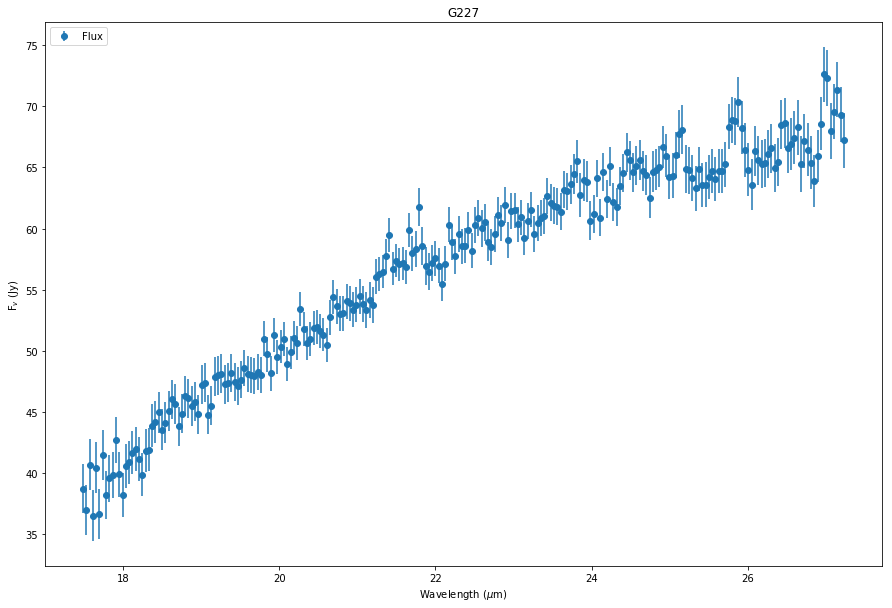

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# ^leave out if in a non-interactive environment

plt.figure(figsize=(15,10))
plt.errorbar(g227['wavelength'],g227['flux'],yerr=g227['error'],fmt='o', label = 'Flux')

plt.title("G227")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend(loc = 'upper left')

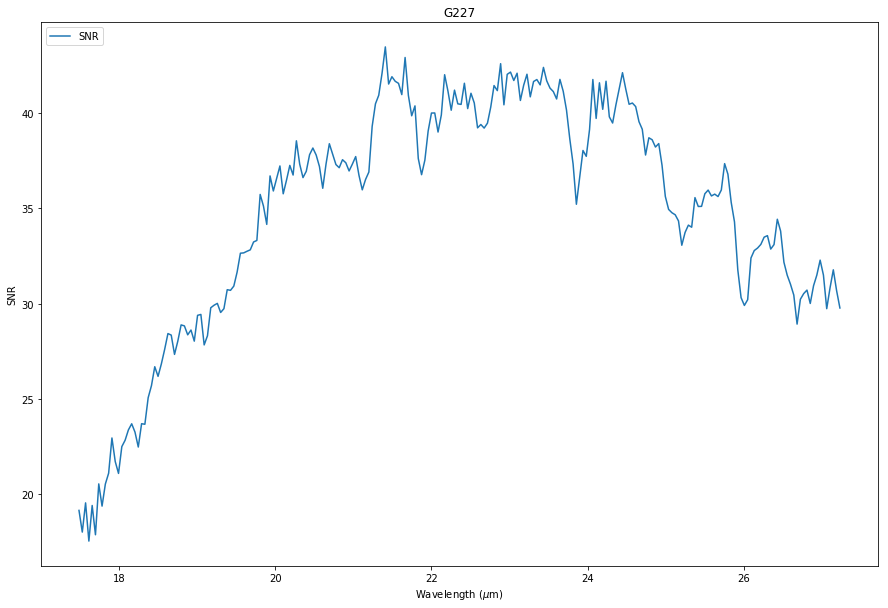

In [4]:
plt.figure(figsize=(15,10))
plt.plot(g227['wavelength'], g227['flux']/g227['error'], label = 'SNR')

plt.title("G227")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('SNR')
plt.legend(loc='upper left')

In order to assess whether any particular features in the spectrum are real or not, it is important to compare the flux to the telluric transmission:

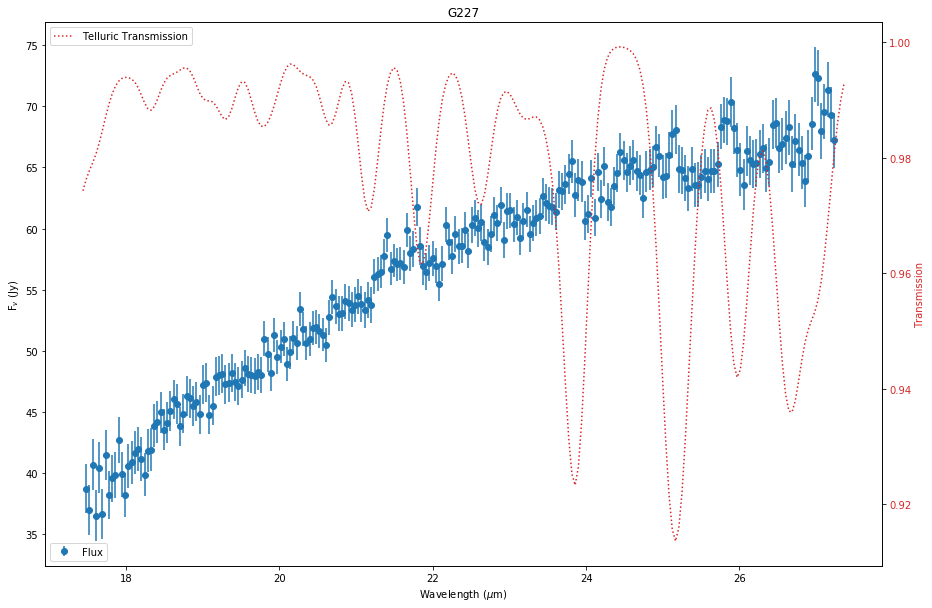

In [5]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g227['wavelength'],g227['flux'],yerr=g227['error'],fmt='o', label = 'Flux')
plt.legend(loc='lower left')

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g227['wavelength'],g227['telluric'], color=color, linestyle=':', label = 'Telluric Transmission')
ax2.tick_params(axis='y', labelcolor=color)
plt.title("G227")
plt.legend(loc='upper left')

It is clear form this plot that most of the "features" in the spectrum are in fact residuals left over from the telluric correction.  It is sometimes possible to improve the correction by careful modelling of the atmospheric lines, but some residuals are almost always present. 

For very low-S/N data, it is useful to look at both the telluric transmission and the response.  Here we'll take a look at the G329 grism data as an example:

Text(0.5,1,'G329')

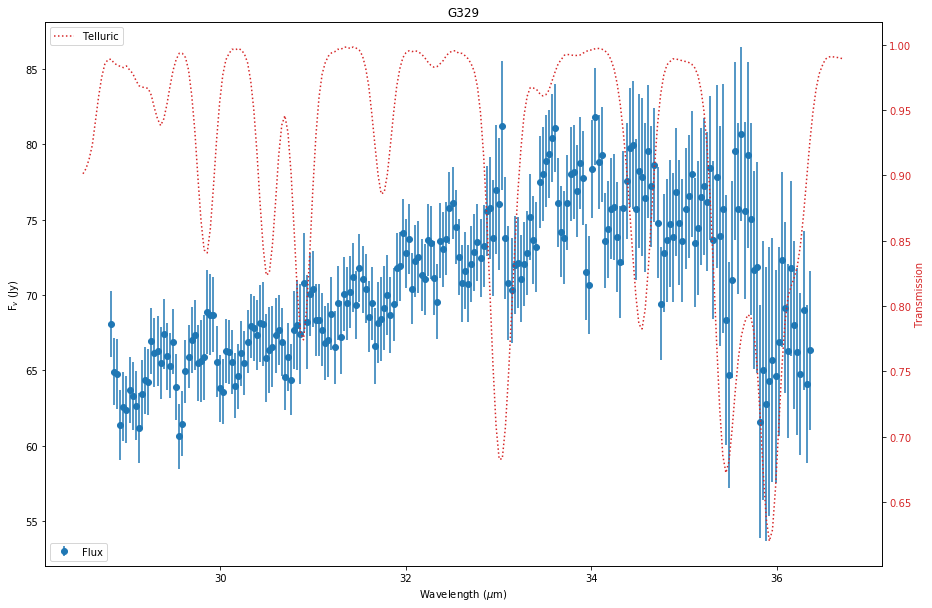

In [6]:
#Read in data for G329 grism using the function we defined earlier:
g329_fits,g329 = loadFORCASTGrismData('forcast-sample-data/F0434_FO_GRI_0501384_FORG329_CMB_0239-0246.fits')


#now plot flux and telluric transmission together
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g329['wavelength'],g329['flux'],yerr=g329['error'],fmt='o', label='Flux')
plt.legend(loc='lower left')

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g329['wavelength'],g329['telluric'], color=color, linestyle=':', label='Telluric')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.title('G329')

Text(0.5,1,'G329')

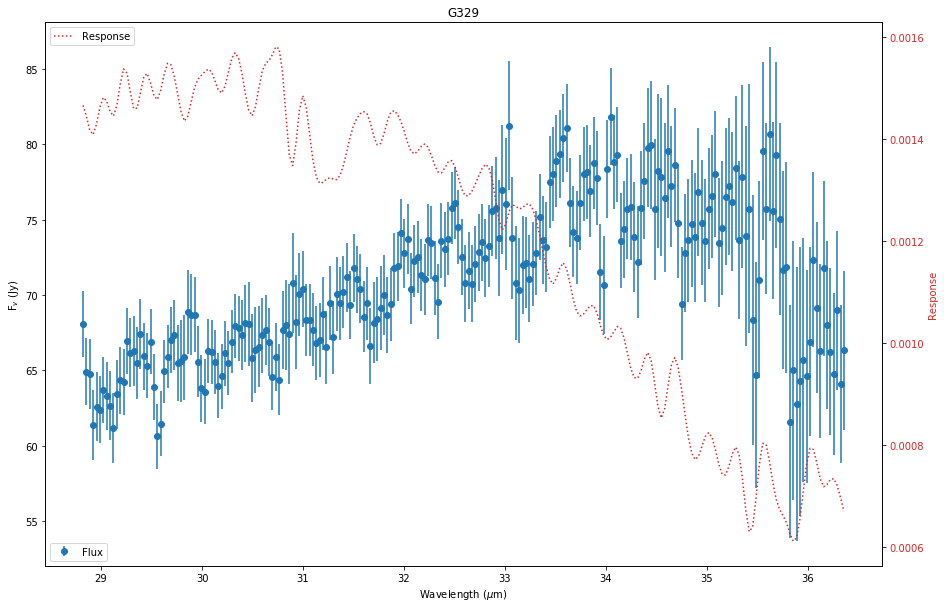

In [7]:
#and now plot flux and response  together
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g329['wavelength'],g329['flux'],yerr=g329['error'],fmt='o',label='Flux')
plt.legend(loc='lower left')

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Response', color=color)
ax2.plot(g329['wavelength'],g329['response'], color=color, linestyle=':',label='Response')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.title('G329')


Due to the strong telluric absorption coupled with relatively low response, the flux values for $\lambda$ > 35 $\mu$m should be viewed with some caution.  

## Masking Regions with Strong Telluric Features

Regions with particularly strong telluric absorption generally suffer from very poor correction and should be masked out.  For example, the G111 grism generally suffers from poor correction at 9.6 $\mu$m due to the very deep telluric O3 band there:

Text(0.5,1,'G111')

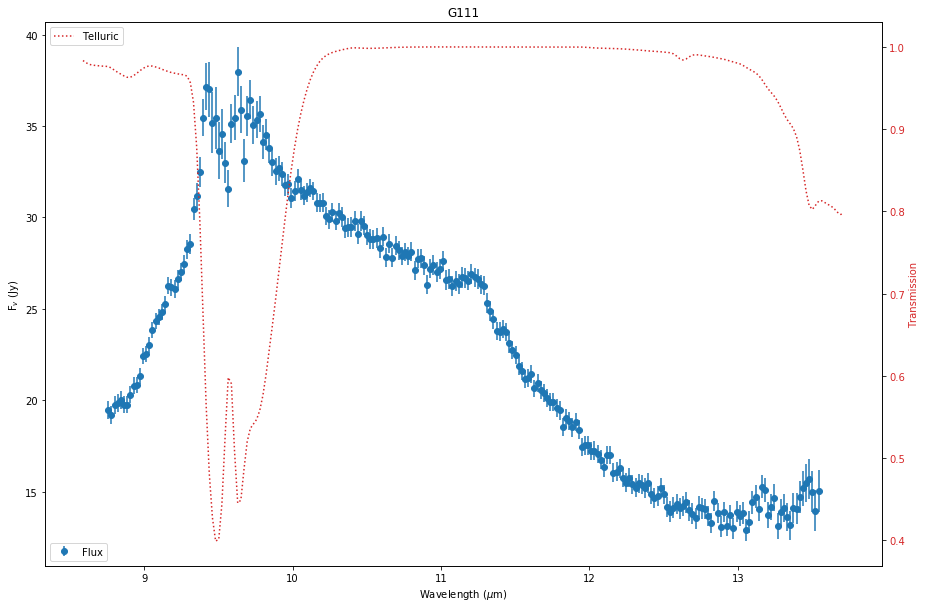

In [8]:
#Read in data for G111 grism using the function we defined earlier:
g111_fits,g111 = loadFORCASTGrismData('forcast-sample-data/F0434_FO_GRI_0501382_FORG111_CMB_0234-0238.fits')


#So now inspect individual grism spectrum, plot flux with errorbars and overplot telluric spectrum
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111['wavelength'],g111['flux'],yerr=g111['error'],fmt='o',label='Flux')
plt.legend(loc='lower left')


color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111['wavelength'],g111['telluric'], color=color, linestyle=':',label='Telluric')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.title('G111')

Now mask out all flux values for which the transmission is less than some threshold (0.7 in this example) and re-plot:

/Users/hamma/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'G111')

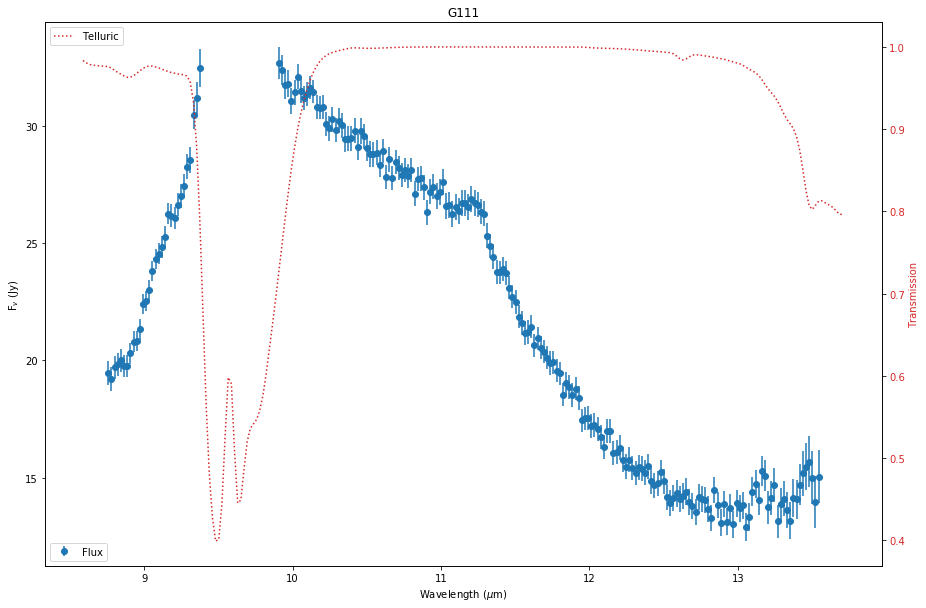

In [9]:
thresh = 0.7
g111['flux'].mask  = g111['telluric'] < thresh
g111['error'].mask = g111['telluric'] < thresh

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111['wavelength'],g111['flux'],yerr=g111['error'],fmt='o',label='Flux')
plt.legend(loc='lower left')


color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111['wavelength'],g111['telluric'], color=color, linestyle=':',label='Telluric')
ax2.tick_params(axis='y', labelcolor=color)
plt.legend(loc='upper left')
plt.title('G111')

## Plotting the Complete SED

Now we can load the last grism data file (G063) and plot the full SED from 5 -- 40 mic.:

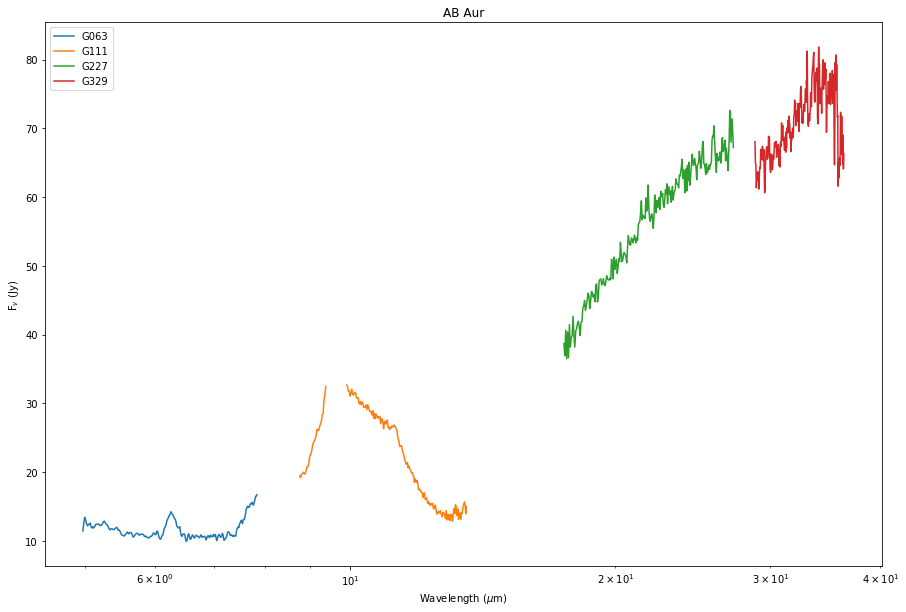

In [10]:
#And finally, read in the G063 data:

g063_fits,g063 = loadFORCASTGrismData('forcast-sample-data/F0434_FO_GRI_0501381_FORG063_CMB_0228-0229.fits')

#Now plot all grism data together as a line plot, semi-log
plt.figure(figsize=(15,10))
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')
plt.semilogx(g329['wavelength'], g329['flux'], label='G329')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()

(Notice that Python automatically uses the masked data for G111.)

The first thing we notice is that there appears to be a flux break or discrepancy between the G227 and G329 grisms, which is most likely due to additional slit losses for the G329 data.

## Dealing with Additional Slit Losses

Since the width of the FORCAST slits are smaller than the SOFIA PSF in general, the slit only "samples" a fraction of the flux from the source.  The FORCAST pipeline accounts for this "loss" automatically for each grism using a default PSF model.  However, if the target is not centered on the slit during the observation, or if the image quality is poor, there can be an additional loss that is *not* accounted for in the pipeline processing.  These additional "slit losses" can be assessed and "fixed" using trusted absolute photometry from the same spectral region.  For the sample data, we also have photometric fluxes for each grism band pass which we use to compare to the grism spectra below.

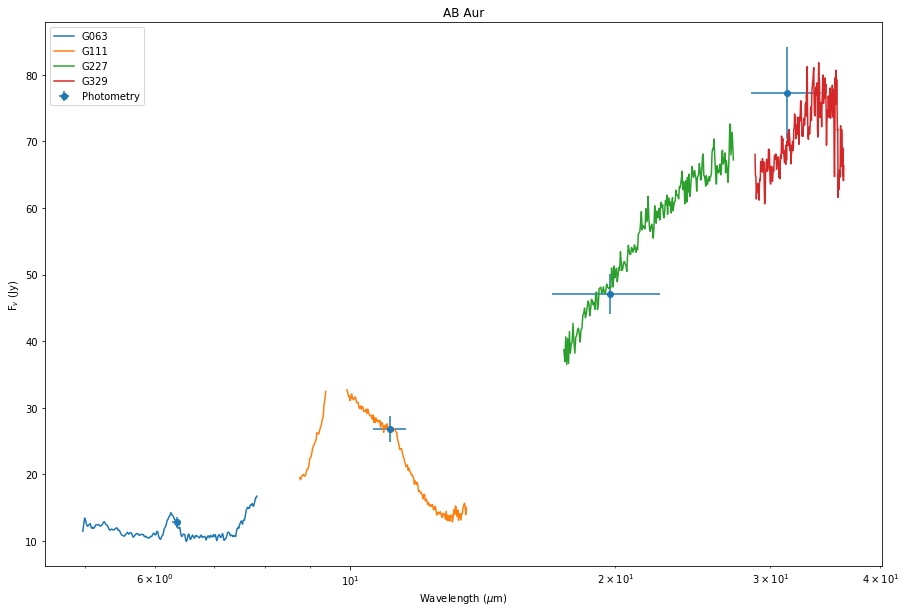

In [11]:
#Create a table of values for the photometry
filters = ['F064','F111','F197','F315']
waves = [6.34774,11.0888,19.6993,31.3615] #microns
delwaves = [0.14,0.95,5.5,5.7]  #filter bandpass (FWHM, microns)
fluxes = [12.854,26.778,47.129,77.264]  #Jy
relerrs = [0.063705,0.073197,0.063439,0.089142] #absolute uncertainty (ratio)


phot = Table([filters,waves,fluxes,relerrs,delwaves], 
                  names=('filter', 'wave', 'flux', 'relerr', 'delwave'),
                  meta={'name': 'Photometry Data Table'})

phot['wave'].unit = 'micron'
phot['delwave'].unit = 'micron'
phot['flux'].unit = 'Jy'

#Now plot all grism data together as a line plot, using semi-log (x-axis)
fp='tab:blue'
plt.figure(figsize=(15,10))
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')
plt.semilogx(g329['wavelength'], g329['flux'], label='G329')


plt.errorbar(phot['wave'],phot['flux'],xerr=0.5*phot['delwave'],yerr=phot['flux']*phot['relerr'],
             fmt='o', color=fp, label = 'Photometry')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()


The grism spectra match up very well with the photometry *except* for G329 which appears too low, most likely due to slit misalignment during the observation.  Assuming the losses are independant of wavelength, the grism data can be shifted up to match the photometric value by simply averaging the grism data over the filter bandpass and applying the difference across the band.  Note that the F315 filter goes to slightly shorter wavelengths than the G329 grism, so we will need to trim the window used for averaging the grism data.

In [12]:
import numpy as np
import numpy.ma as ma

#Set hi/lo boundaries of sample window for averaging the grism data
lo = phot['wave'][3] - 0.45*phot['delwave'][3] #trim by 0.45 since imaging bandpass is slight larger than grism range.
hi = phot['wave'][3] + 0.45*phot['delwave'][3]
g329_f = g329['flux']  #put fluxes in tmp array for convenience

#calculate mean for the [lo,hi] window
g329_mean = ma.mean(g329_f[(g329['wavelength'] < hi) & (g329['wavelength'] > lo)])  

#and shift the spectrum up by the difference
g329_f_adj = g329_f + (phot['flux'][3] - g329_mean)

#and add to the data table
g329['flux_adj'] = g329_f_adj
g329['flux_adj'].unit = 'Jy'
g329.pprint()

    wavelength            flux       ...        response            flux_adj    
      micron               Jy        ...         Jy / s                Jy       
------------------ ----------------- ... --------------------- -----------------
28.519786834716797               nan ...                   nan               nan
 28.55327796936035               nan ...                   nan               nan
 28.58677101135254               nan ...                   nan               nan
28.620262145996094               nan ...                   nan               nan
 28.65375328063965               nan ...                   nan               nan
28.687246322631836               nan ...                   nan               nan
 28.72073745727539               nan ...                   nan               nan
28.754228591918945               nan ...                   nan               nan
28.787721633911133               nan ...                   nan               nan
28.821212768554688 68.055358

Here we've added an extra column for the new "adjusted" flux spectrum.  Now re-plot with the adjusted values for G329: 

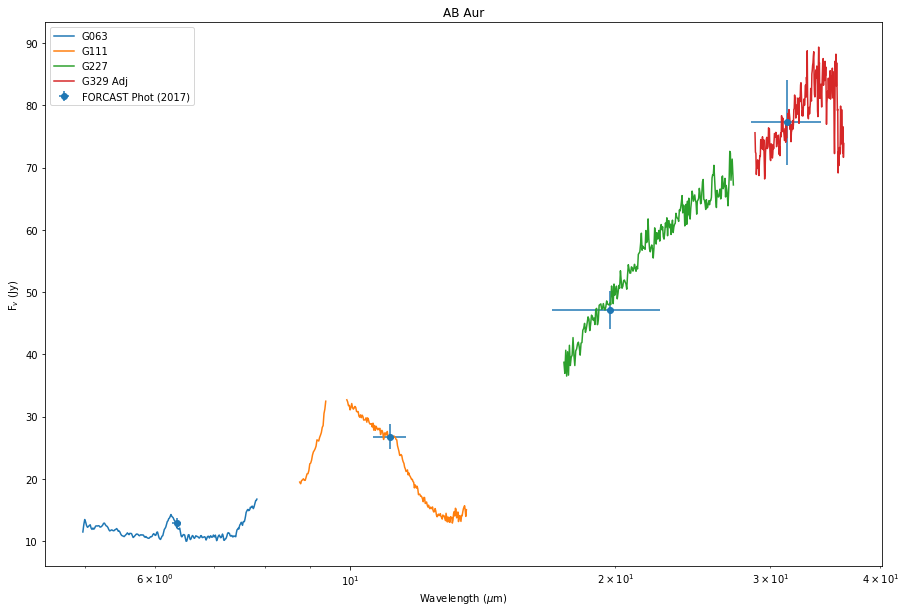

In [13]:
fp='tab:blue'
plt.figure(figsize=(15,10))

# plot all grism settings
plt.semilogx(g063['wavelength'], g063['flux'], label='G063')
plt.semilogx(g111['wavelength'], g111['flux'], label='G111')
plt.semilogx(g227['wavelength'], g227['flux'], label='G227')

# plot adjusted spectrum for g329
plt.semilogx(g329['wavelength'], g329['flux_adj'], label='G329 Adj')  # <--- Adjusted spectrum

plt.errorbar(phot['wave'],phot['flux'],xerr=0.5*phot['delwave'],yerr=phot['flux']*phot['relerr'],
                 fmt='o', color=fp, label = 'FORCAST Phot (2017)')

plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()

The adjusted G329 spectrum now matches the G227 spectrum very nicely.  

## Converting to $\lambda$F$_{\lambda}$

We often want to work with $\lambda$F$_{\lambda}$ in order to assess where the object is emitting the most power (per logade or decade).  AstroPy quantities and constants makes this easy.  Remember that $\lambda$F$_{\lambda}$ = $v$F$_v$ = c * F$_v$ / $\lambda$.


In [14]:
#Calculate lam f_lam (= nu F_nu = c * F_nu / lambda), convert to W/m^2, and add to table with mask if it exists.

lamflam=const.c * g063['flux']/g063['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g063['lamflam'] = lamflam  #...put in table...

lamflam=const.c * g111['flux']/g111['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g111['lamflam'] = lamflam  #...put in table...
g111['lamflam'].mask = g111['flux'].mask  #...and dont forget to mask lamflam as well.

lamflam=const.c * g227['flux']/g227['wavelength']  #calculate 
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g227['lamflam'] = lamflam  #...put in table...

lamflam=const.c * g329['flux_adj']/g329['wavelength']  #calculate using adjusted flux
lamflam=lamflam.to(u.W / (u.m * u.m))  #and convert to W/m^2
g329['lamflam'] = lamflam  #...put in table...

g111.info

<Table masked=True length=242>
   name     dtype   unit  n_bad
---------- ------- ------ -----
wavelength float64 micron     0
      flux float64     Jy    24
     error float64     Jy    24
  telluric float64            0
  response float64 Jy / s     0
   lamflam float64 W / m2    24

We've retained MKS units, but it is easy to convert to CGS from here if desired.

And now re-plot with $\lambda$F$_{\lambda}$:

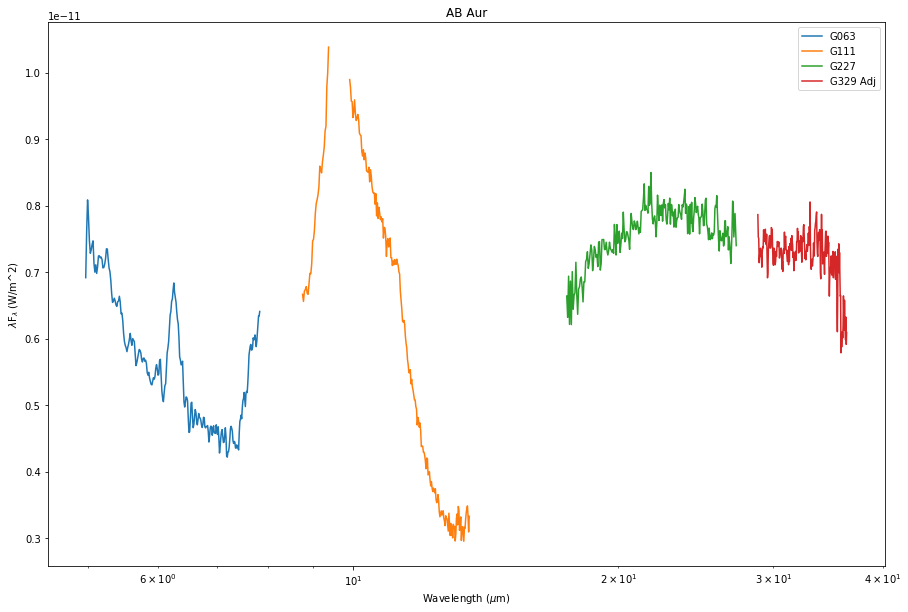

In [15]:
fp='tab:blue'
plt.figure(figsize=(15,10))

# plot all grism settings
plt.semilogx(g063['wavelength'], g063['lamflam'], label='G063')
plt.semilogx(g111['wavelength'], g111['lamflam'], label='G111')
plt.semilogx(g227['wavelength'], g227['lamflam'], label='G227')

# plot adjusted spectrum for g329
plt.semilogx(g329['wavelength'], g329['lamflam'], label='G329 Adj')  # <--- Adjusted spectrum
    
plt.title("AB Aur")
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\lambda$F$_{\lambda}$ (W/m^2)')
plt.legend()